In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from models import marginal_normal_model
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

numpyro.set_host_device_count(8)
numpyro.enable_x64()
sns.set_theme('notebook', 'ticks', 'colorblind')

Let's build a reasonable LIGO-ish observational model.  We're gonna do BBH systems here (because why not).  So the true masses are distributed as a power law in $m_1$, power law in $q$ conditional on $m_1$, gaussian in $\chi_\mathrm{eff}$ with a small offset mean, and delta-function in $\delta \phi$.  The variable ordering is $\delta \phi$, $\chi_\mathrm{eff}$, $q$, $m_1$.

In [3]:
nobs = 100
nnormal = 2
ndim = 4

alpha_true = 2.35
beta_true = 1 # p(q) ~ q^beta => p(1/q) d(1/q) = p(q) dq => p(1/q) 1/q^2 dq = p(q) dq => p(1/q) = q^2 p(q) => p(1/q) = (1/q)^-(beta+2)
chi_mu = 0.1
chi_sigma = 0.15

delta_phis = np.zeros(nobs)
chi_eff = np.random.normal(loc=chi_mu, scale=chi_sigma, size=nobs)
q_invs = 1 + np.random.pareto(beta_true+1, size=nobs)
qs = 1/q_invs
m1s = 1 + np.random.pareto(alpha_true-1, size=nobs)

The observational model is a bit different, and meant to be evocative of the sorts of correlations among observed variables that occur in the pN expansion.  Let 
$$
M_c = m_1 \frac{q^{3/5}}{\left( 1 + q \right)^{1/5}}
$$
be the chirp mass.  Then let "observed" variables 
$$
x = \log M_c + \delta \phi
$$
$$
y = \log M_c + q
$$
$$
z = \log M_c - q
$$
and 
$$
w = (1 + q) \chi_\mathrm{eff}.
$$

Let the observational uncertainties be independent and Gaussian with 
$$
\sigma_{x,y,z,w} = \left[ 0.01, 0.1, 0.1, 0.1 \right].
$$

The code below implements this observational model, and produces posterior samples over $\delta \phi$, $\chi_\mathrm{eff}$, $q$, and $m_1$.

In [4]:
mcs = m1s * qs**(3/5) / (1+qs)**(1/5)
xts = np.log(mcs) + delta_phis
yts = np.log(mcs) + qs
zts = np.log(mcs) - qs
wts = (1 + qs)*chi_eff

xos = np.random.normal(loc=xts, scale=0.01)
yos = np.random.normal(loc=yts, scale=0.1)
zos = np.random.normal(loc=zts, scale=0.1)
wos = np.random.normal(loc=wts, scale=0.1)

In [5]:
nsamp = 128

dpsamps = []
cesamps = []
qsamps = []
m1samps = []
for i in tqdm(range(nobs)):
    xo = xos[i]
    yo = yos[i]
    zo = zos[i]
    wo = wos[i]

    xsamps = np.random.normal(loc=xo, scale=0.01, size=nsamp)
    ysamps = np.random.normal(loc=yo, scale=0.1, size=nsamp)
    zsamps = np.random.normal(loc=zo, scale=0.1, size=nsamp)
    wsamps = np.random.normal(loc=wo, scale=0.1, size=nsamp)

    mc = np.exp(0.5*(ysamps + zsamps))
    q = 0.5*(ysamps - zsamps)
    dp = xsamps - np.log(mc)
    ce = wsamps / (1 + q)
    m1 = mc / (q**(3/5)/(1+q)**(1/5))

    while np.any(q < 0) or np.any(q > 1) or np.any(m1 < 1):
        s = (q < 0) | (q > 1) | (m1 < 1)
        n = np.sum(s)

        xsamps = np.random.normal(loc=xo, scale=0.01, size=n)
        ysamps = np.random.normal(loc=yo, scale=0.1, size=n)
        zsamps = np.random.normal(loc=zo, scale=0.1, size=n)
        wsamps = np.random.normal(loc=wo, scale=0.1, size=n)

        mc[s] = np.exp(0.5*(ysamps + zsamps))
        q[s] = 0.5*(ysamps - zsamps)
        dp[s] = xsamps - np.log(mc[s])
        ce[s] = wsamps / (1 + q[s])
        m1[s] = mc[s] / (q[s]**(3/5) / (1 + q[s])**(1/5))
    dpsamps.append(dp)
    cesamps.append(ce)
    qsamps.append(q)
    m1samps.append(m1)

dpsamps = np.array(dpsamps)
cesamps = np.array(cesamps)
qsamps = np.array(qsamps)
m1samps = np.array(m1samps)

normal_wts = np.ones_like(m1samps)
other_wts = 2*(1+qsamps)/m1samps

samples = np.stack((dpsamps, cesamps, qsamps, m1samps), axis=2)

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/kh/yn7djbsx35vb_gqd5m31brm00000gq/T/ipykernel_77734/3886111987.py:22: RuntimeWarning: invalid value encountered in power
  m1 = mc / (q**(3/5)/(1+q)**(1/5))


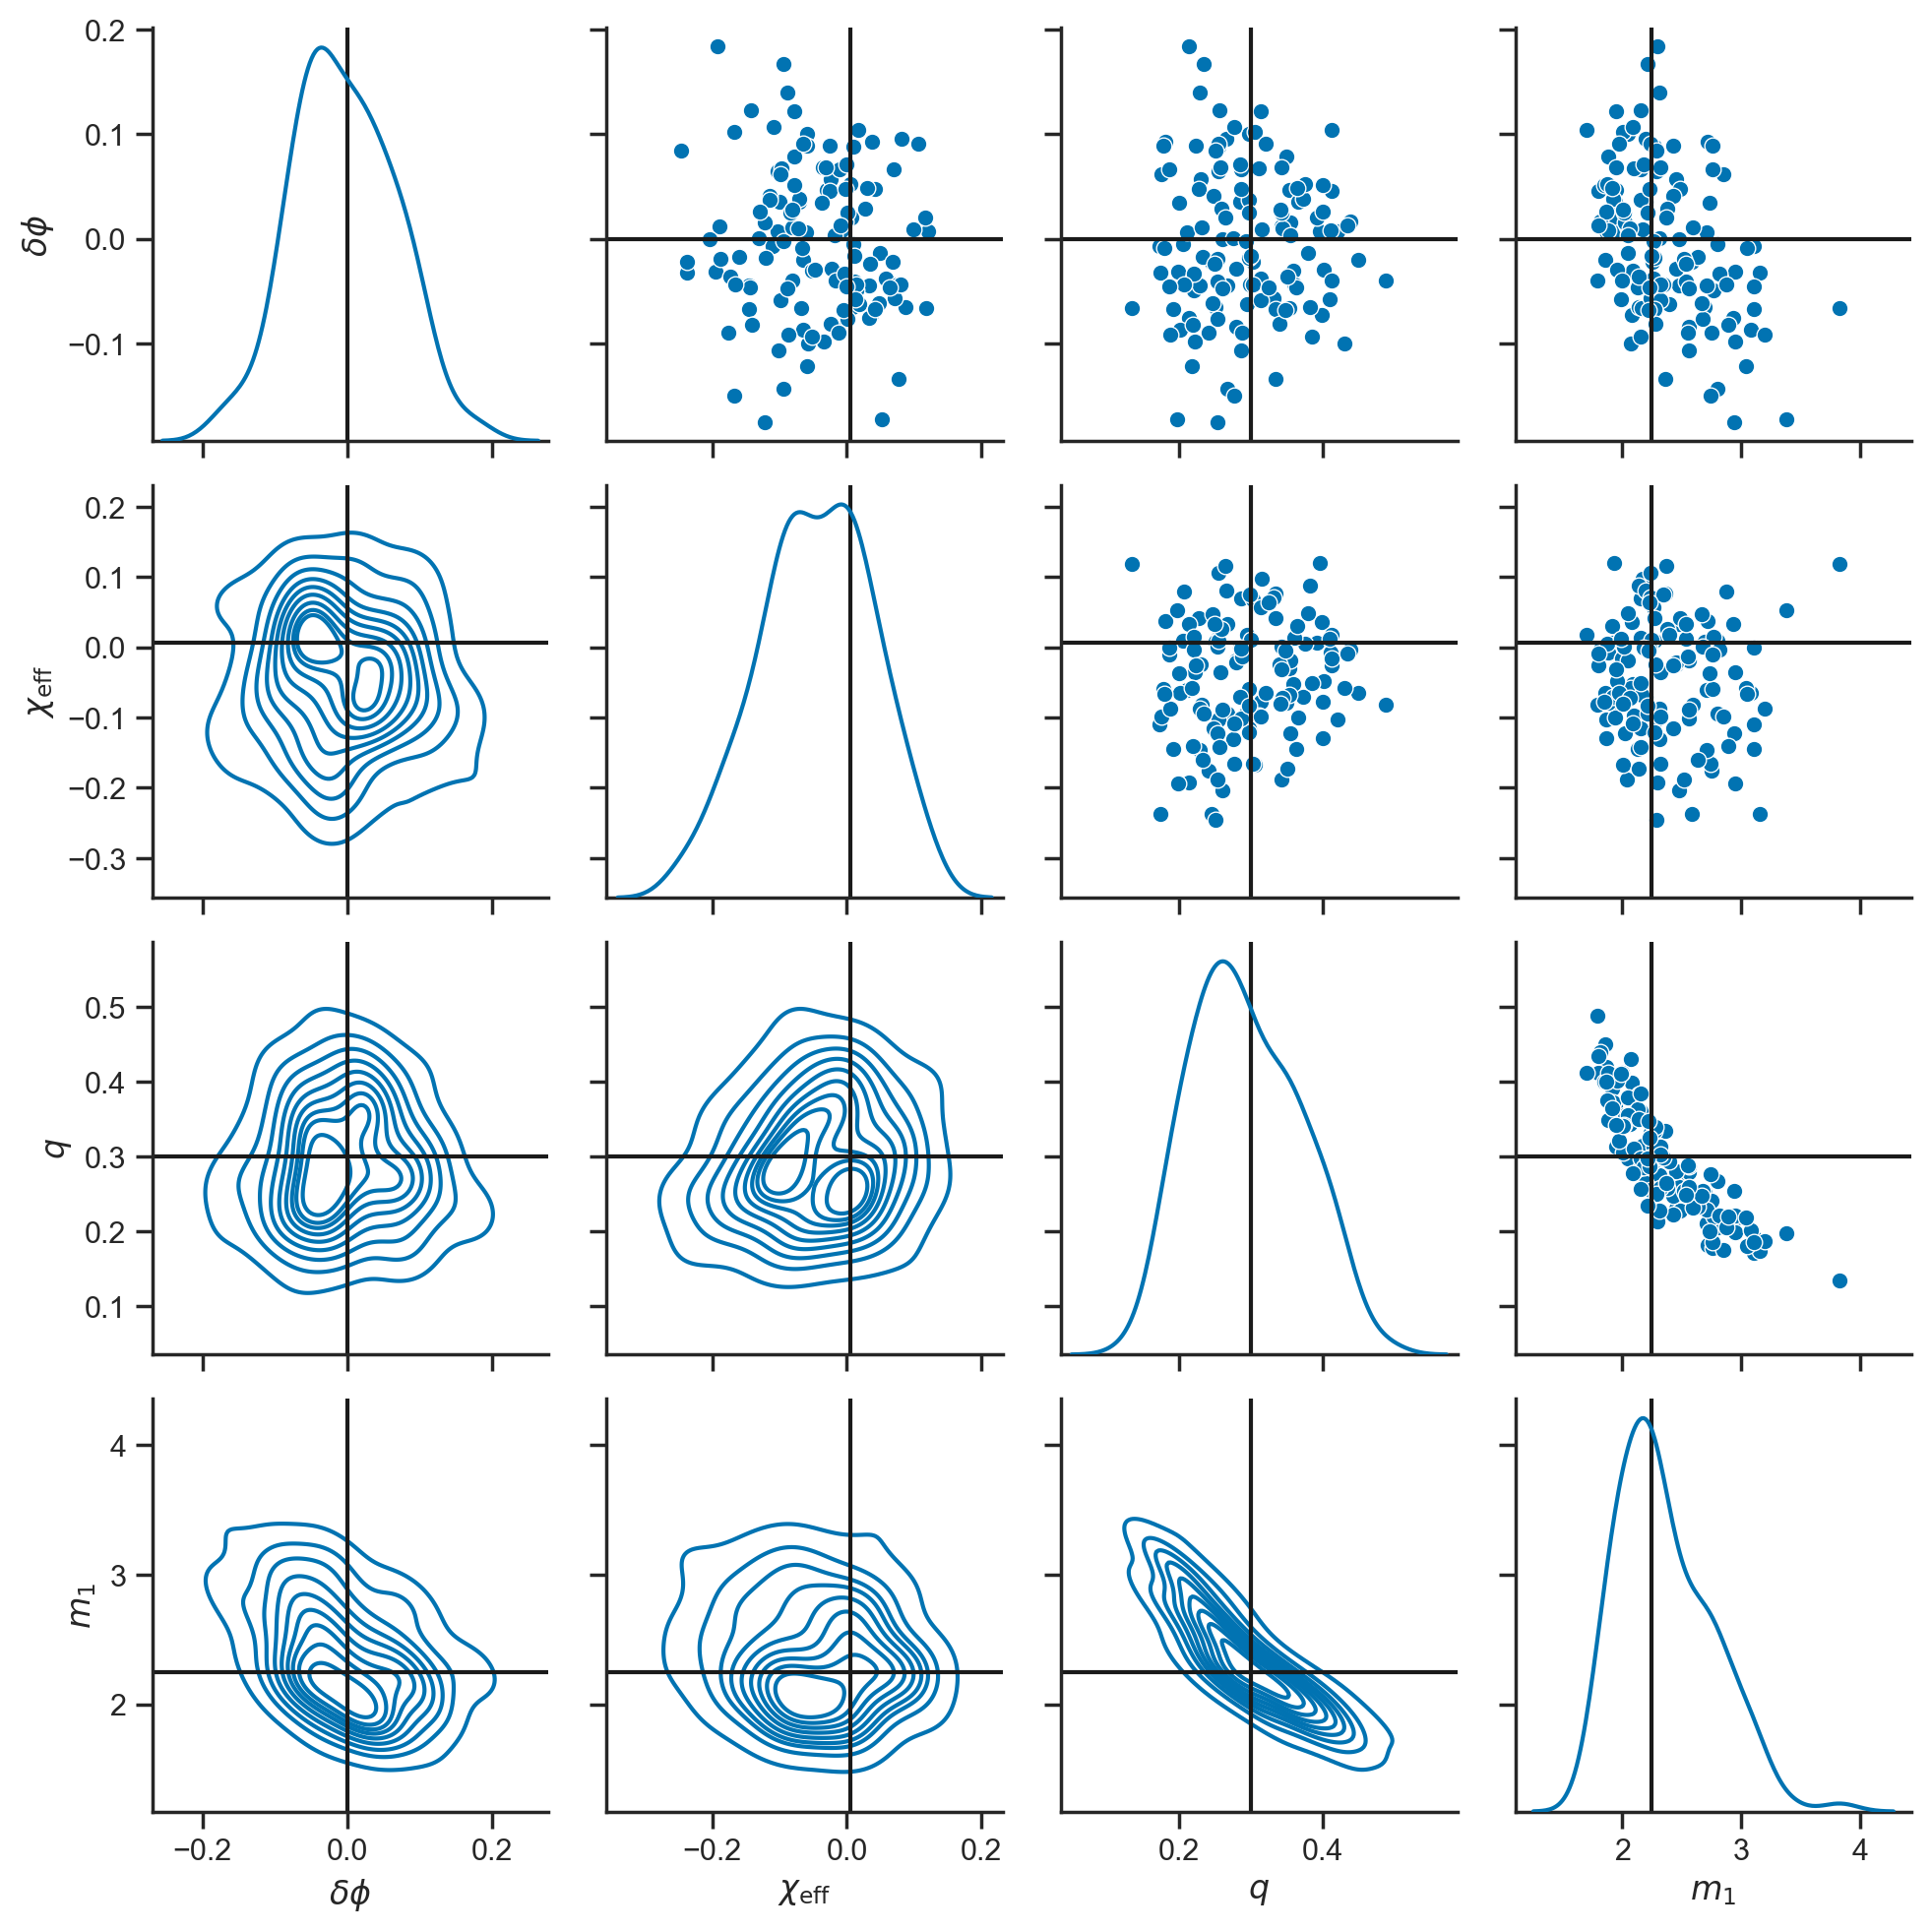

In [6]:
i = np.random.randint(nobs)
df = pd.DataFrame(data=samples[i,:,:], columns=[r'$\delta \phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

t = [delta_phis[i], chi_eff[i], qs[i], m1s[i]]
for ii in range(4):
    for jj in range(4):
        if ii == jj:
            pg.axes[ii,jj].axvline(t[ii], color='k')
        else:
            pg.axes[ii,jj].axhline(t[ii], color='k')
            pg.axes[ii,jj].axvline(t[jj], color='k')

In [7]:
def full_model(marginal_model, samples, prior_wts, n_normal, *args, predictive=False, **kwargs):
    alpha = numpyro.sample('alpha', dist.Uniform(1, 4))
    beta = numpyro.sample('beta', dist.Uniform(0, 4))

    def log_p_other(s):
        q = s[..., 0]
        m1 = s[..., 1]

        log_m1 = jnp.log(jnp.abs(m1))
        log_q = jnp.log(jnp.abs(q))

        log_smooth_m = jnp.where(m1 < 1, -0.5*jnp.square(log_m1/0.05), 0)

        return beta*log_q + jnp.log1p(beta) - alpha*log_m1 + jnp.log(alpha - 1) + log_smooth_m
    
    marginal_model(log_p_other, samples, prior_wts, n_normal, *args, predictive=predictive, **kwargs)

    if predictive:
        qinv = numpyro.sample('qinv', dist.Pareto(1, beta+1))
        q = numpyro.deterministic('q', 1/qinv)

        m1 = numpyro.sample('m1', dist.Pareto(1, alpha-1))

In [8]:
nmcmc = 1000
nchain = 4

kernel = NUTS(full_model, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=nmcmc, num_samples=nmcmc, num_chains=nchain)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), marginal_normal_model, samples, normal_wts*other_wts, nnormal)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [9]:
pred = Predictive(full_model, mcmc.get_samples())
pred = pred(jax.random.PRNGKey(np.random.randint(1<<32)), marginal_normal_model, samples, normal_wts*other_wts, nnormal, predictive=True)

In [10]:
a_pred = pred['theta']

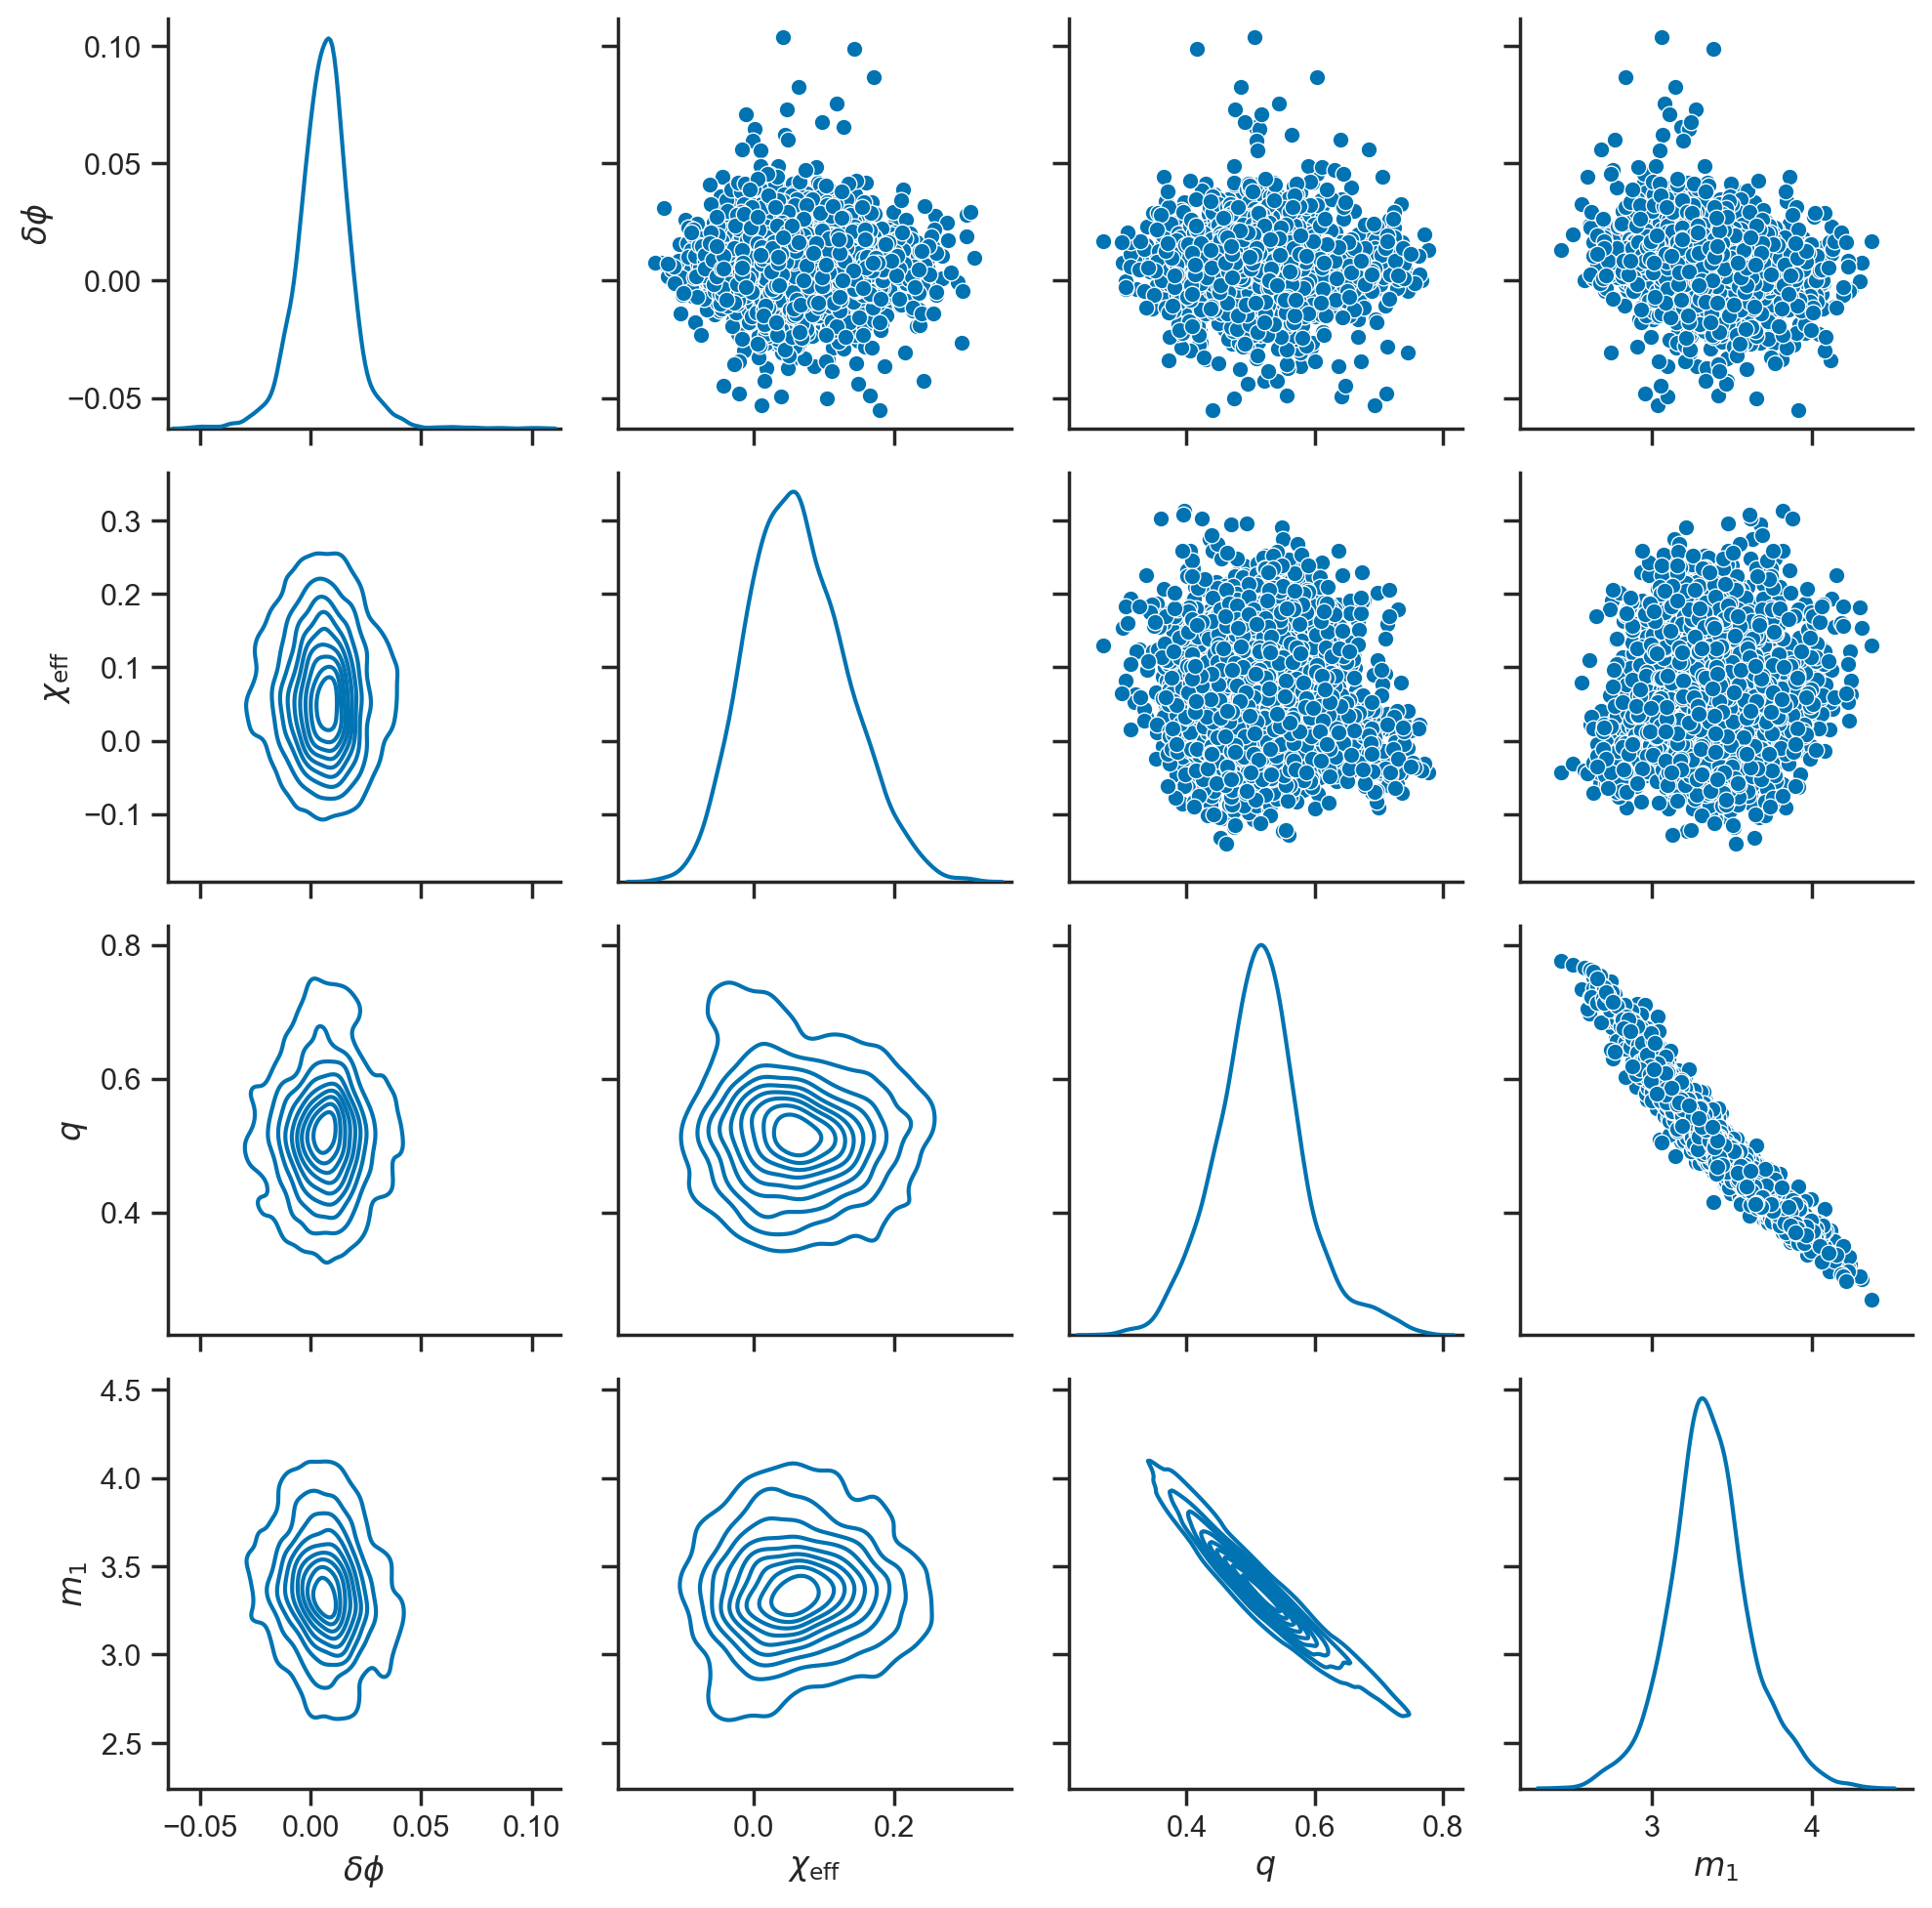

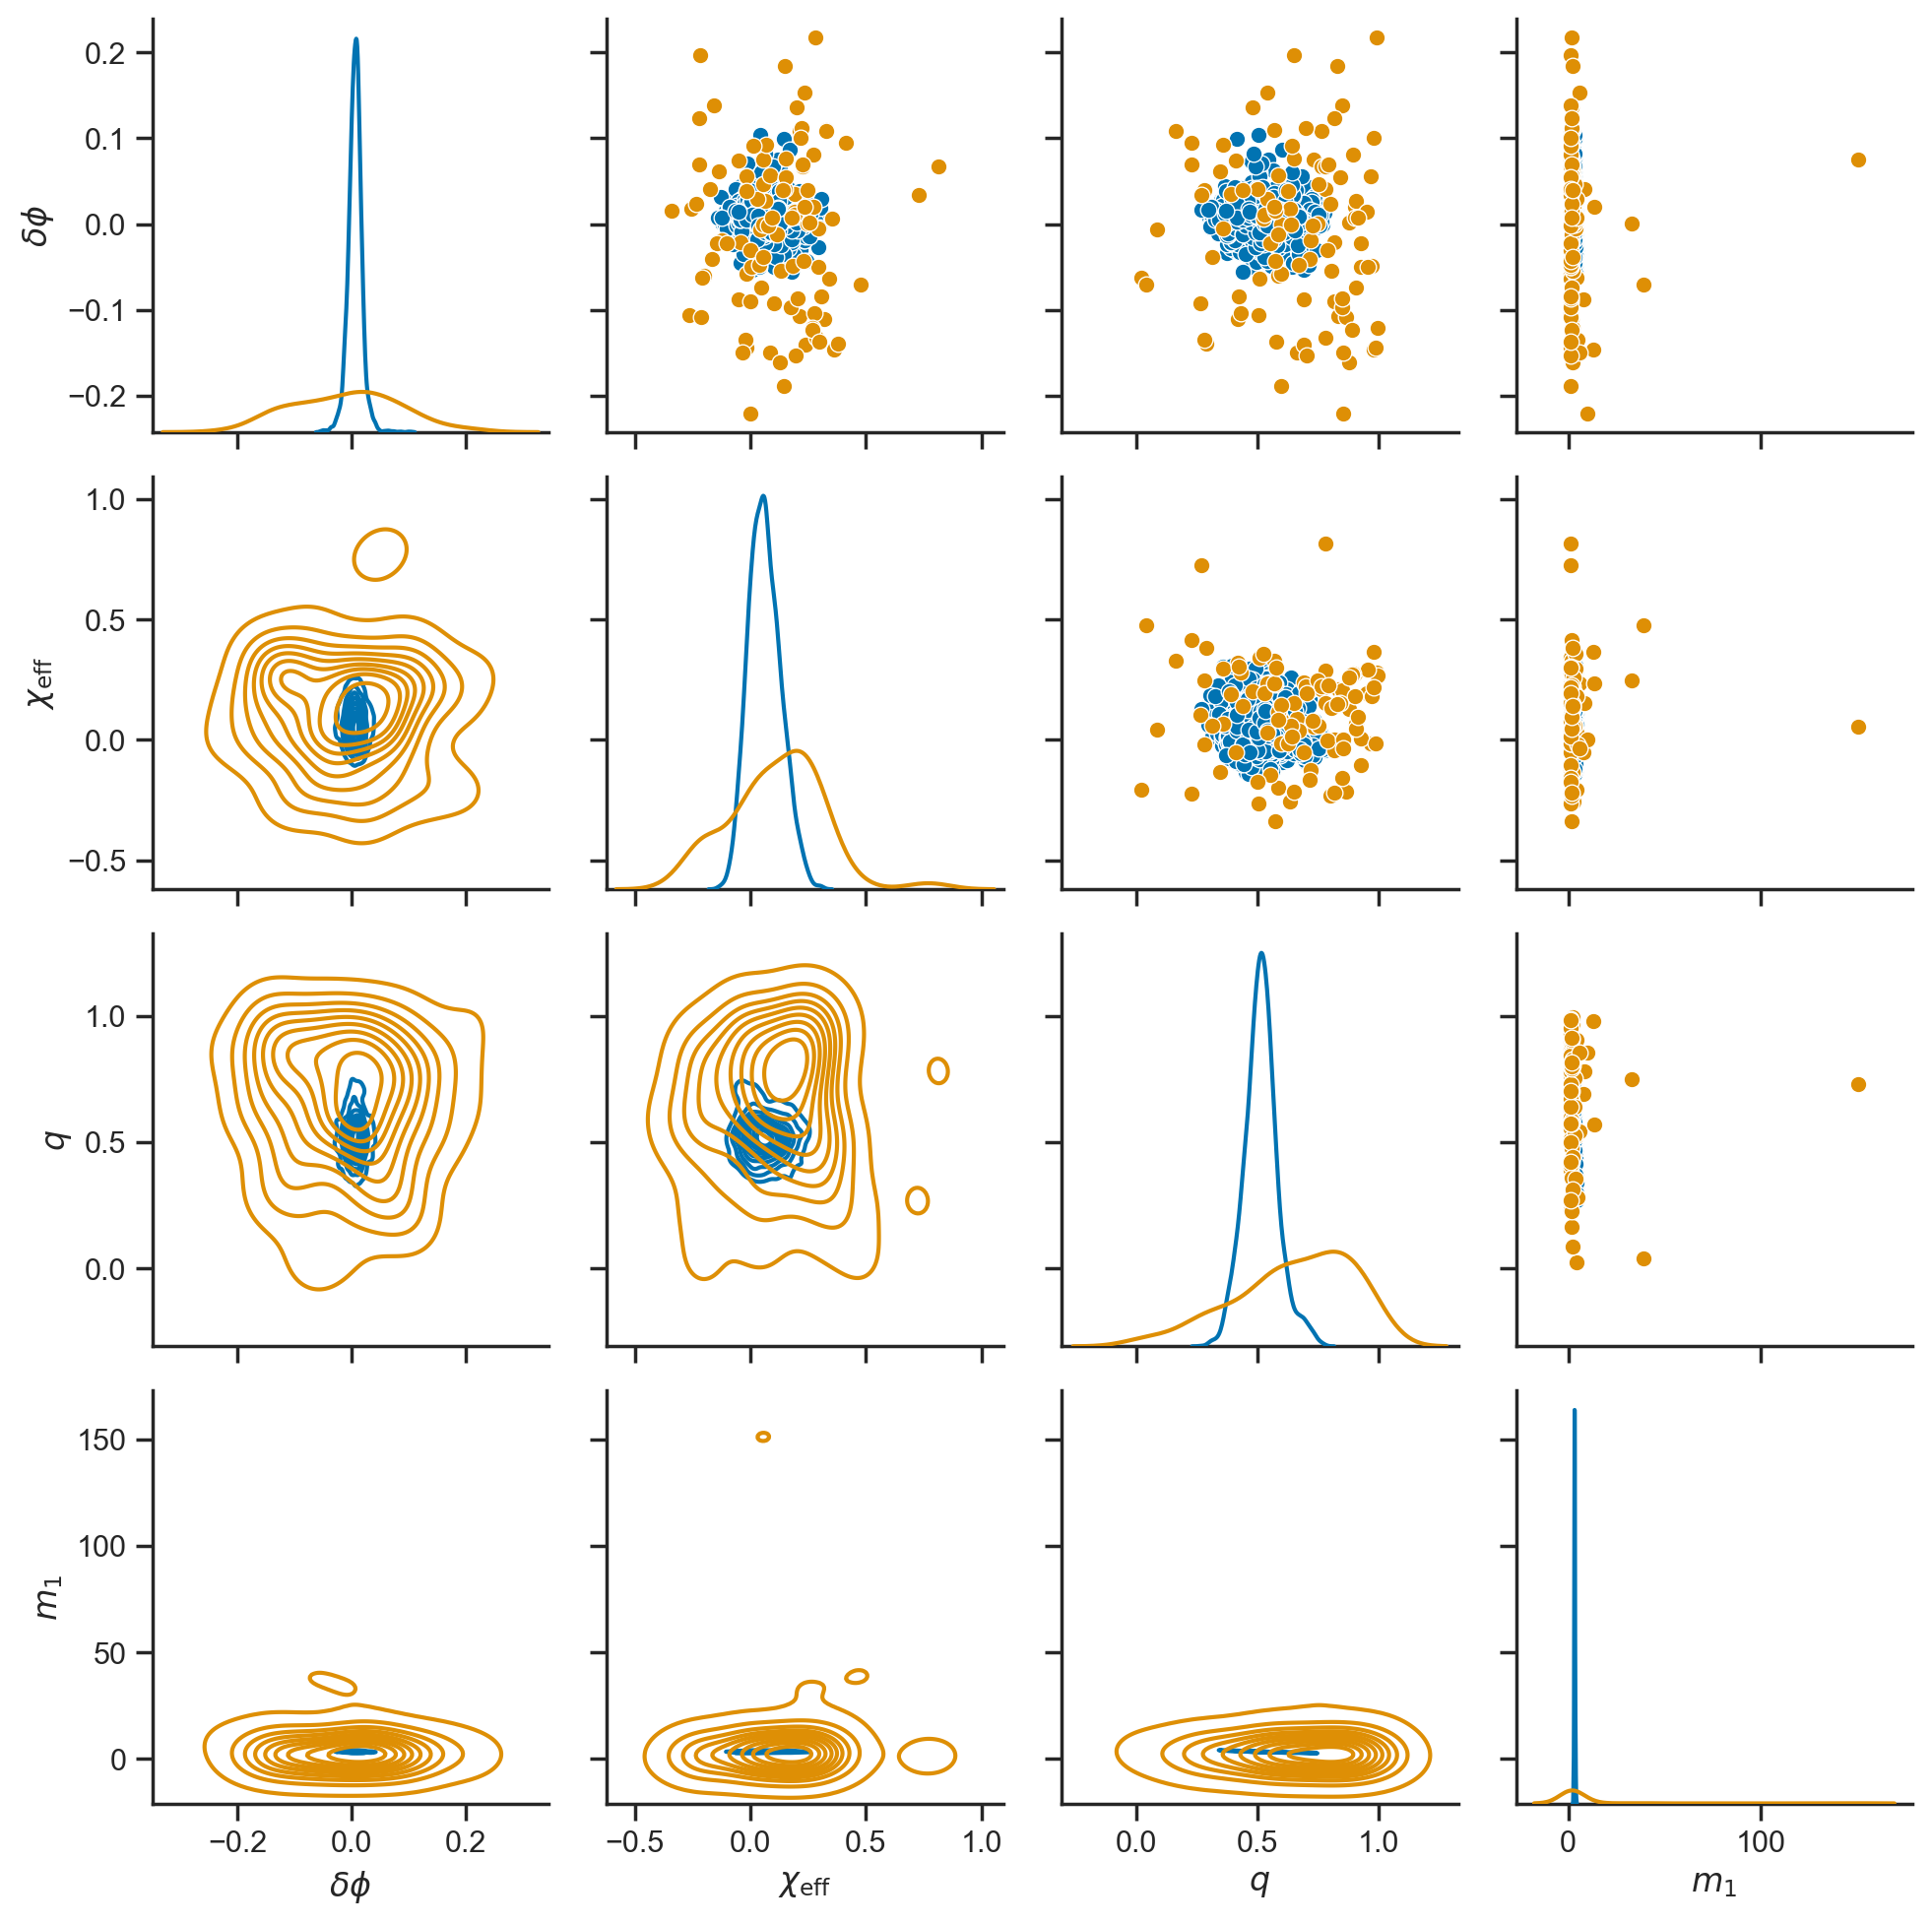

In [11]:
i = np.random.randint(nobs)
df = pd.DataFrame(a_pred[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

pg = sns.PairGrid(df, diag_sharey=False)
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

df = pd.DataFrame(samples[:,i,:], columns=[r'$\delta\phi$', r'$\chi_\mathrm{eff}$', r'$q$', r'$m_1$'])
pg.data = df
pg.map_diag(sns.kdeplot)
pg.map_lower(sns.kdeplot)
pg.map_upper(sns.scatterplot)

In [12]:
trace = az.from_numpyro(mcmc)

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'neff'}>,
        <Axes: title={'center': 'neff'}>]], dtype=object)

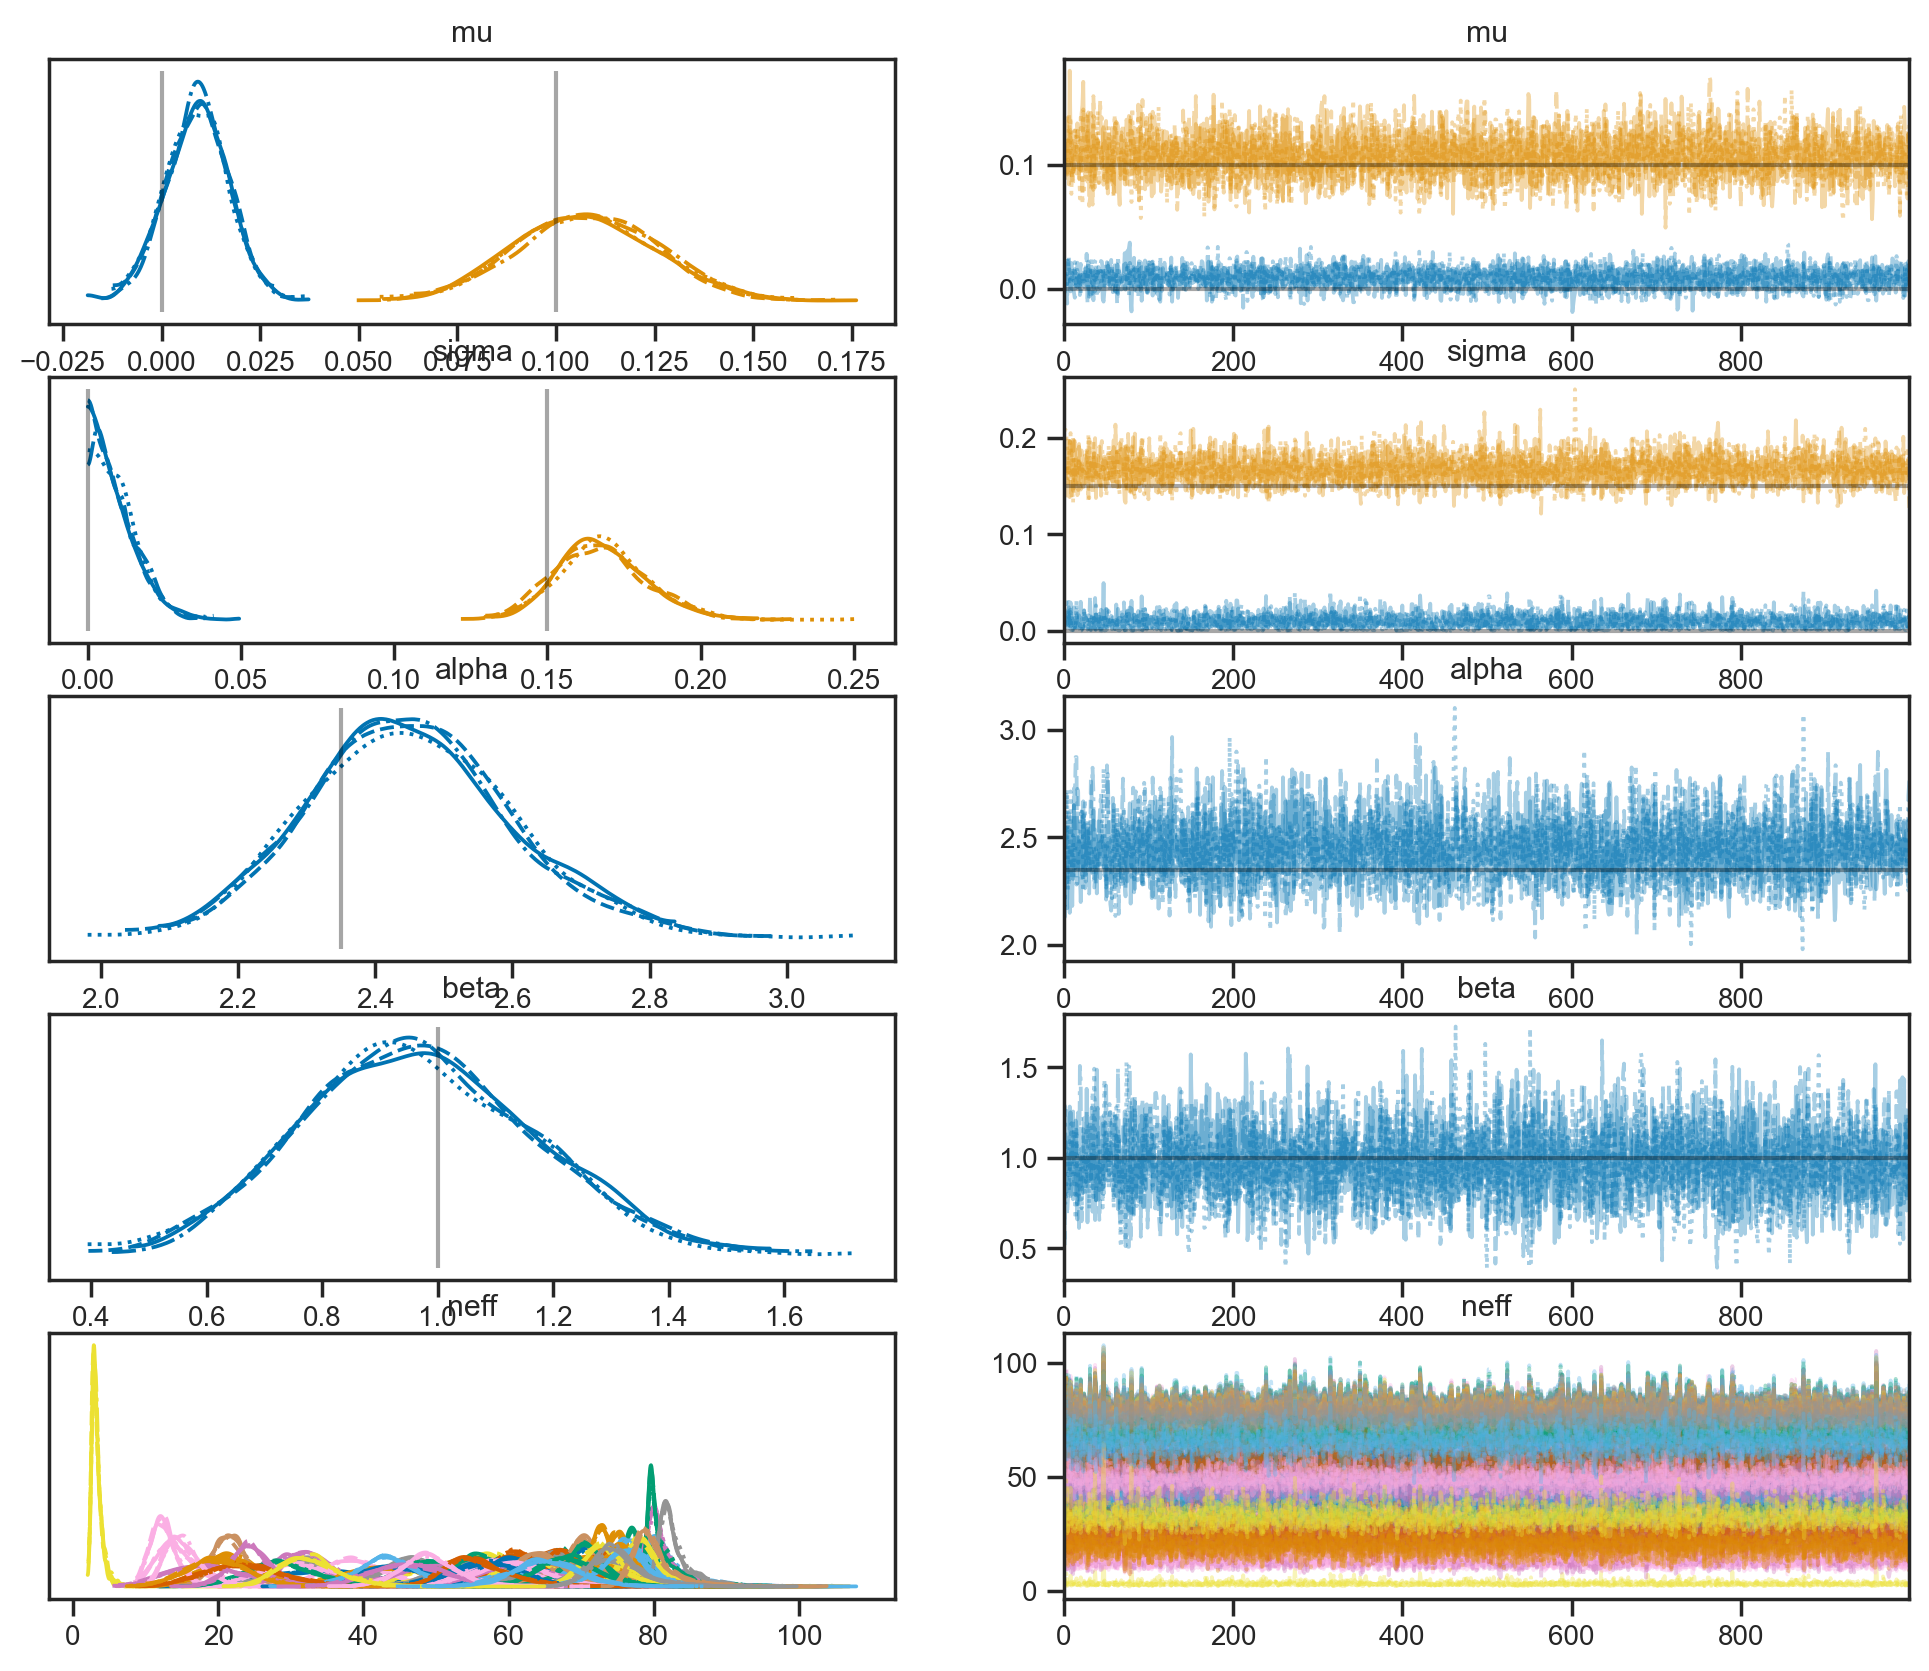

In [13]:
az.plot_trace(trace, var_names=['mu', 'sigma', 'alpha', 'beta', 'neff'], lines=[('mu', {}, np.array([0.0, chi_mu])), ('sigma', {}, np.array([0.0, chi_sigma])), 
                                                                                ('alpha', {}, alpha_true), ('beta', {}, beta_true)])

Text(0.5, 0, '$\\delta \\phi$')

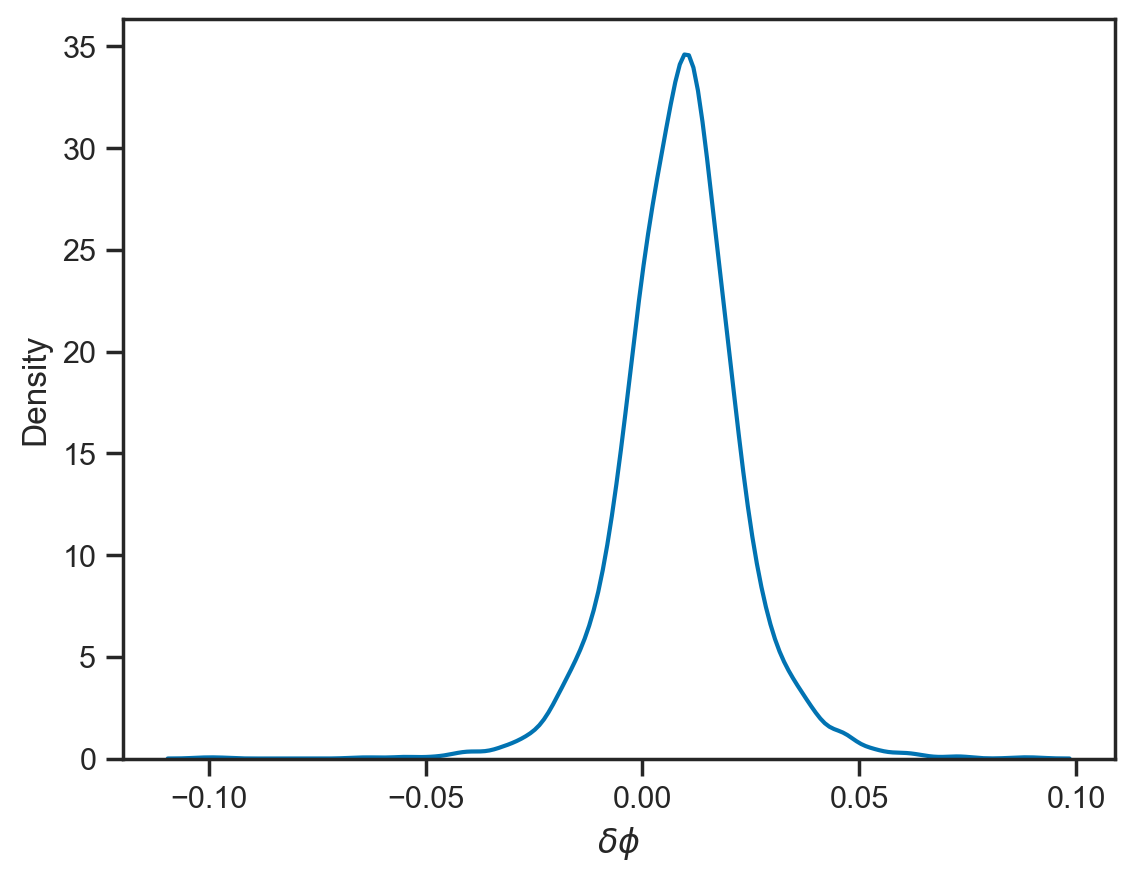

In [14]:
sns.kdeplot(pred['theta_gaussian_draw'][:,0])
plt.xlabel(r'$\delta \phi$')

Text(0.5, 0, '$\\chi_\\mathrm{eff}$')

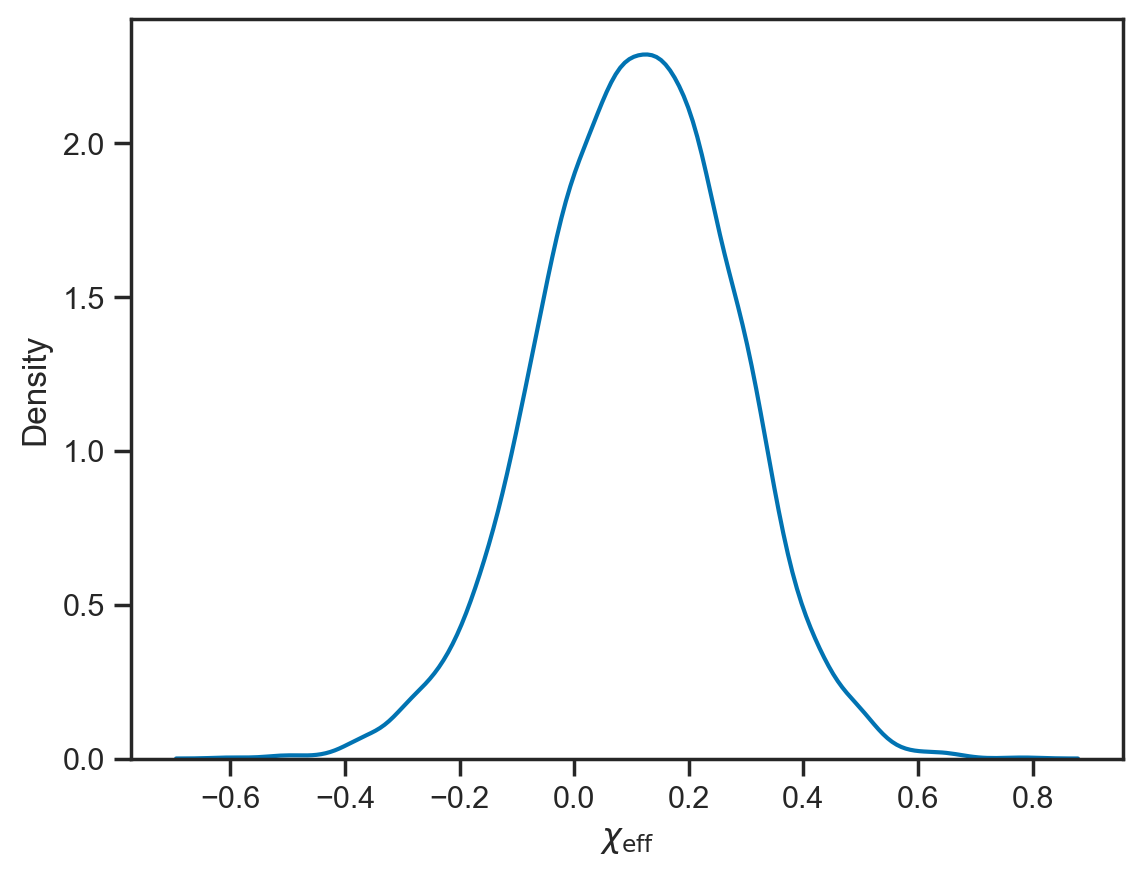

In [15]:
sns.kdeplot(pred['theta_gaussian_draw'][:,1])
plt.xlabel(r'$\chi_\mathrm{eff}$')

Text(0.5, 0, '$m_1$')

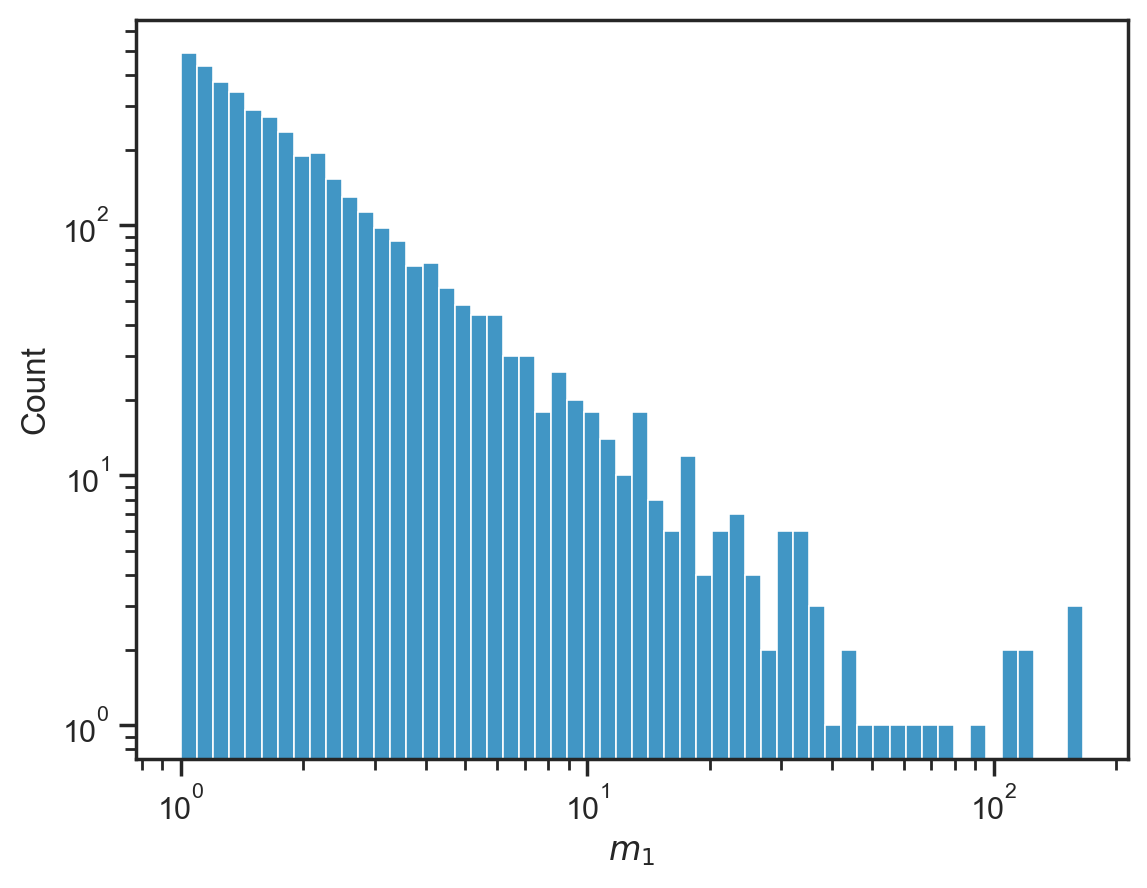

In [16]:
sns.histplot(pred['m1'], log_scale=True)
plt.yscale('log')
plt.xlabel('$m_1$')